In [1]:
# Import libraries and set desired options

from __future__ import division, print_function
# Disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import FastICA, TruncatedSVD

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances, manhattan_distances

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
def analyze_results(cv_res):
    import re 
    
    results = pd.DataFrame(cv_res['params'])
    results['mean_score'] = cv_res['mean_test_score']
    results['std_score'] = cv_res['std_test_score']
    results['rank'] = cv_res['rank_test_score']
#     results = results.sort_values('rank')
    
    n_splits = len(cv_res['split0_test_score'])
    cv_results = np.r_[[clf.cv_results_[k] for k in clf.cv_results_.keys() if re.match(r'split\d+_test', k)]]
    cv_results = pd.DataFrame(cv_results)
    melted = cv_results.melt()
    melted['split_num'] = list(range(cv_results.shape[0])) * cv_results.shape[1]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'width_ratios':[2, 1]})
    
    sns.barplot(x='split_num', y='value', hue='variable', data=melted, ax=axes[0, 0]);
    axes[0, 0].set_ylim(melted['value'].min()-.01, 1);
    
    sns.violinplot(x='variable', y='value', hue='variable', data=cv_results.melt(), ax=axes[0, 1], dodge=False);
    sns.boxplot(x='variable', y='value', data=melted, ax=axes[1, 0]);
    sns.barplot(x=results.index, y='std_score', data=results, ax=axes[1, 1]);
    
    sns.despine()
    return results, cv_results

## Load data

In [4]:
# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [5]:
df_users = pd.read_csv('data/data_users.csv', index_col=0)
df_users.head(3)

,data,user
0,270 270 270 21 21 7832 21 7832 30 7832 29 7832...,Alice_log
1,63 66 53 52 49 52 21 196 52 197 52 55 56 55 58...,user2227
2,1 63 167 23 21 23 22 812 22 676 39 21 21 679 2...,user1666


In [61]:
df_alice = pd.read_csv('data/Alice_log.csv')
df_alice['site'] = df_alice['site'].map(sites_dict.reset_index().set_index('site').iloc[:, 0])

top_sites = dict()
for i in [5, 10, 25, 50, 100, 250, 500, 1000]:
    top_sites['top'+str(i)] = df_alice['site'].value_counts()[:i].index

In [7]:
# Read the training and test data sets
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id')
# train_df = pd.read_csv('data/data_full.csv', index_col=0)
# train_df = train_df.drop(['for_folds', 'user'], axis=1)

test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

In [8]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [9]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

# Index to split the training and test data sets
idx_split = train_df.shape[0]

### get time features

In [10]:
def get_time_features(df):
    time_df = pd.DataFrame(index=df.index)
    
    time_df['hour'] = df['time1'].dt.hour
    time_df['day_'] = df['time1'].dt.day
    time_df['month'] = df['time1'].dt.month
    time_df['year'] = df['time1'].dt.year
    time_df['myear'] = df['time1'].dt.year * 12 + df['time1'].dt.month
    
#     hour = df['time1'].apply(lambda ts: ts.hour)
#     time_df['orig_spl0'] = ((hour >= 7) & (hour <= 11)).astype('int')
#     time_df['orig_spl1'] = ((hour >= 12) & (hour <= 18)).astype('int')
#     time_df['orig_spl2'] = ((hour >= 19) & (hour <= 23)).astype('int')

#     month = df['time1'].dt.month
#     month[month<=2] = month[month<=2] + 12
#     cutted = pd.cut(month, bins=[0, 5, 8, 11, 100], labels=[str(num) for num in range(4)])
#     month_dum = pd.get_dummies(cutted, prefix='month', prefix_sep='')
#     time_df = pd.concat([time_df, month_dum], axis=1)
    
    time_df['minutes'] = df['time1'].dt.hour * 60 + df['time1'].dt.minute
    time_df['minutes_sin'] = np.sin(2*np.pi*time_df['minutes']/1440.)
    time_df['minutes_cos'] = np.cos(2*np.pi*time_df['minutes']/1440.)
    time_df['n_null'] = df[times].isnull().sum(axis=1)
         
    for bins_spl in [[-1, 720, 1140, 100000]]:
        cutted = pd.cut(time_df['minutes'], bins=bins_spl, labels=[str(num)+'b' for num in range(len(bins_spl)-1)])
        hours_dum = pd.get_dummies(cutted, prefix=str(len(bins_spl))+'_spl', prefix_sep='')
        time_df = pd.concat([time_df, hours_dum], axis=1)

    time_df['dow'] = df['time1'].apply(lambda ts: ts.date().weekday())
    dtimes = ['dt'+str(i) for i in range(2, 11)]
    for i in range(2, 11):
        time_df['dt'+str(i)] = (df['time'+str(i)] - df['time'+str(i-1)]).astype('timedelta64[s]')
    time_df['dt'] = time_df[dtimes].mean(axis=1).fillna(0)
    time_df['dt_std'] = time_df[dtimes].std(axis=1).fillna(0)
    
    for i in range(2, 11):
        del time_df['dt'+str(i)]

    return time_df

In [11]:
full_time = get_time_features(full_df[times])
ft_columns = full_time.columns

# hours_dum = pd.get_dummies(pd.cut(full_time['hour'], bins=4, labels=['1', '2', '3', '4']), prefix='spl', prefix_sep='')
# full_time = pd.concat([full_time, hours_dum], axis=1)
print(ft_columns)

Index(['hour', 'day_', 'month', 'year', 'myear', 'minutes', 'minutes_sin',
       'minutes_cos', 'n_null', '4_spl0b', '4_spl1b', '4_spl2b', 'dow', 'dt',
       'dt_std'],
      dtype='object')


### get site features

In [12]:
text_cols = ['sites_num']
df_text = pd.DataFrame(columns=text_cols)
df_text['sites_num'] = full_sites.astype('str').apply(lambda x: ' '.join(x), axis=1)

for k in top_sites.keys():
    df_text[k] = full_sites.isin(top_sites[k]).sum(axis=1)

### pairs feat

In [13]:
pairs_tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
u_df = pairs_tfidf.fit_transform(df_users['data'])
s_df = pairs_tfidf.transform(df_text['sites_num'])
df_text['cosd'] = cosine_distances(s_df, u_df[0])
df_text['cos'] = cosine_similarity(s_df, u_df[0])
df_text['euc'] = euclidean_distances(s_df, u_df[0])
df_text['manh'] = manhattan_distances(s_df, u_df[0])

df_text['cosd'] = df_text['cosd'].apply(lambda x:np.power(x, 40))
df_text['cos'] = df_text['cos'].apply(lambda x:np.power(x, .2))
df_text['euc'] = df_text['euc'].apply(lambda x:np.power(x, 50))

### concat features

In [14]:
X_train = pd.concat([df_text.iloc[:idx_split], full_time.iloc[:idx_split]], axis=1)
X_test = pd.concat([df_text.iloc[idx_split:], full_time.iloc[idx_split:]], axis=1)

X_train.tail(1)

,sites_num,top5,top10,top25,top50,top100,top250,top500,top1000,cosd,...,minutes,minutes_sin,minutes_cos,n_null,4_spl0b,4_spl1b,4_spl2b,dow,dt,dt_std
session_id,,,,,,,,,,,,,,,,,,,,,
204762,222 3346 3346 3359 55 2891 3346 0 0 0,0,0,0,0,0,0,0,0,1.0,...,1419,-0.091502,0.995805,3,0,0,1,2,2.0,2.75681


# EDA

In [62]:
df_alice['timestamp'] = pd.to_datetime(df_alice['timestamp'])

In [63]:
df_alice.head()

,timestamp,site
0,2013-02-12 16:25:10,270
1,2013-02-12 16:25:11,270
2,2013-02-12 16:32:10,270
3,2013-02-12 16:32:11,21
4,2013-02-12 16:32:24,21


In [64]:
df_alice['group'] = 6
df_alice.loc[df_alice['timestamp'] < '2013.06.01', 'group'] = 1
df_alice.loc[(df_alice['timestamp'] >= '2013.06.01') & (df_alice['timestamp'] < '2013.10.01'), 'group'] = 2
df_alice.loc[(df_alice['timestamp'] >= '2013.10.01') & (df_alice['timestamp'] < '2013.12.15'), 'group'] = 3
df_alice.loc[(df_alice['timestamp'] >= '2013.12.15') & (df_alice['timestamp'] < '2014.02.10'), 'group'] = 4
df_alice.loc[(df_alice['timestamp'] >= '2014.02.10') & (df_alice['timestamp'] < '2014.03.15'), 'group'] = 5

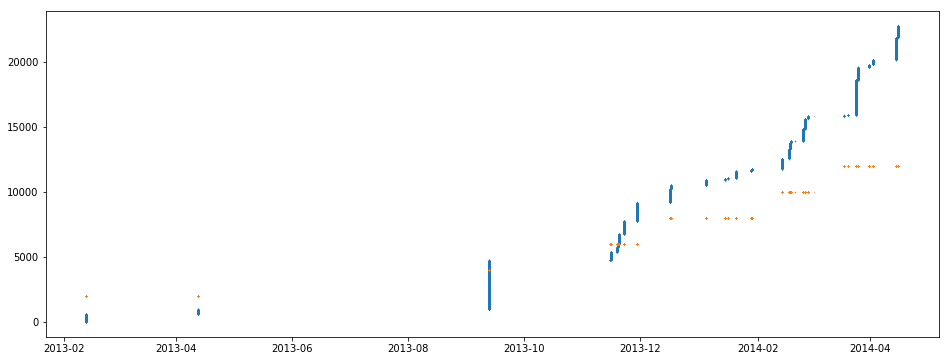

In [39]:
plt.figure(figsize = (16,6))
ax = plt.plot(df_alice['timestamp'], df_alice.index.tolist(), lw=0, marker='o', ms=0.2);
ax = plt.plot(df_alice['timestamp'], df_alice['group']*2000, lw=0, marker='o', ms=0.2);

In [65]:
df_alice['hour'] = df_alice['timestamp'].dt.hour
df_alice.loc[df_alice['hour']==9, 'hour'] = 10
df_alice['weekday'] = df_alice['timestamp'].apply(lambda ts: ts.date().weekday())+1
df_alice['hw'] = df_alice['weekday']*100 + df_alice['hour']

a = df_alice['site'].value_counts()
df_alice['vc'] = df_alice['site'].map(a)



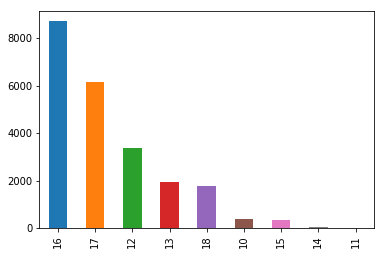

In [76]:
df_alice['hour'].value_counts().plot(kind='bar');

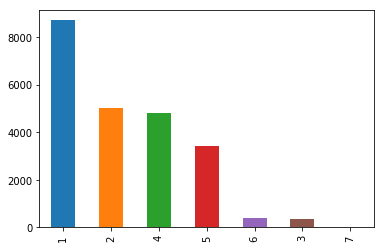

In [77]:
df_alice['weekday'].value_counts().plot(kind='bar');

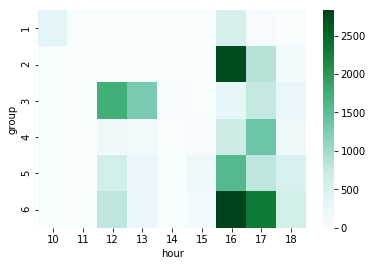

In [66]:
sns.heatmap(pd.crosstab(df_alice['group'], df_alice['hour']), cmap='BuGn');

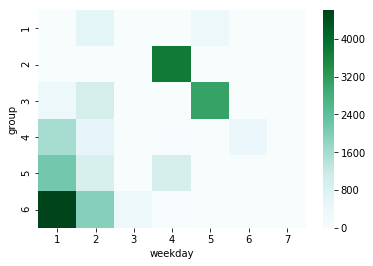

In [67]:
sns.heatmap(pd.crosstab(df_alice['group'], df_alice['weekday']), cmap='BuGn');

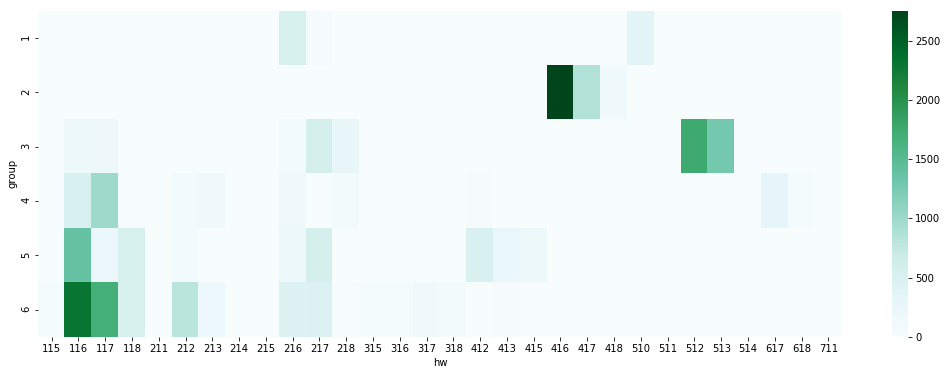

In [72]:
plt.figure(figsize = (18,6))
ax = sns.heatmap(pd.crosstab(df_alice['group'], df_alice['hw']), cmap='BuGn');

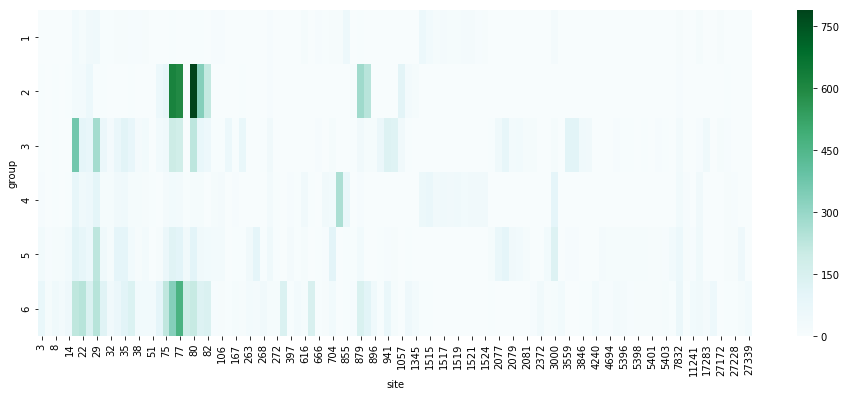

In [58]:
plt.figure(figsize = (16,6))
ax = sns.heatmap(pd.crosstab(df_alice.loc[df_alice['vc'] > 30, 'group'], df_alice.loc[df_alice['vc'] > 30, 'site']), cmap='BuGn');

In [25]:
df_alice['myear'] = (df_alice['timestamp'].dt.year - df_alice['timestamp'].dt.year.min()) * 12 + df_alice['timestamp'].dt.month
df_alice['hour'] = df_alice['timestamp'].dt.hour
df_alice['dt'] = (df_alice['timestamp'] - df_alice['timestamp'].shift(1)).dt.seconds
df_alice['dow'] = df_alice['timestamp'].apply(lambda ts: ts.date().weekday())

In [26]:
df_alice.head()

,timestamp,site,myear,hour,dt,dow
0,2013-02-12 16:25:10,270,2,16,NaN,1
1,2013-02-12 16:25:11,270,2,16,1.0,1
2,2013-02-12 16:32:10,270,2,16,419.0,1
3,2013-02-12 16:32:11,21,2,16,1.0,1
4,2013-02-12 16:32:24,21,2,16,13.0,1


In [27]:
df_alice['myear'].value_counts()

11    4440
14    4049
15    3961
9     3762
16    2998
12    1328
13    1253
2      606
4      372
Name: myear, dtype: int64

In [28]:
# for my in df_alice['myear'].unique():
#     print(f"Month {my}")
#     print(df_alice.loc[df_alice['myear']==my, 'site'].value_counts()[:10].index)
#     print()
top = df_alice['site'].value_counts()[:50].index

df_plot = pd.crosstab(df_alice.loc[df_alice['site'].isin(top), 'site'], df_alice.loc[df_alice['site'].isin(top), 'myear'])
df_plot_h = pd.crosstab(df_alice['hour'], df_alice['myear'])
df_plot_dow = pd.crosstab(df_alice['dow'], df_alice['myear'])

In [29]:
df_alice.groupby('myear')['dt'].describe()

,count,mean,std,min,25%,50%,75%,max
myear,,,,,,,,
2,605.0,11.287603,99.063395,0.0,0.0,0.0,1.0,1565.0
4,372.0,146.336022,2749.254228,0.0,0.0,0.0,1.0,53029.0
9,3762.0,8.526847,381.206025,0.0,0.0,1.0,2.0,23374.0
11,4440.0,73.796396,2183.986220,0.0,0.0,1.0,2.0,80734.0
12,1328.0,66.027108,1809.960965,0.0,0.0,1.0,2.0,65237.0
13,1253.0,219.538707,3693.138595,0.0,0.0,0.0,1.0,78185.0
14,4049.0,82.816498,2247.605867,0.0,0.0,1.0,1.0,78182.0
15,3961.0,66.836657,2070.394689,0.0,0.0,1.0,1.0,84777.0
16,2998.0,88.035357,2537.653697,0.0,0.0,1.0,2.0,83240.0


In [30]:
for i in range(len(df_plot.columns)):
    z = cosine_similarity(df_plot.iloc[:, i].values.reshape(1, -1), df_plot.iloc[:, -1].values.reshape(1, -1))
    zz = cosine_similarity(df_plot_h.iloc[:, i].values.reshape(1, -1), df_plot_h.iloc[:, -2].values.reshape(1, -1))
    print(f'Col {df_plot.columns[i]:<2}: Site:{z[0][0]:.4f} Hour:{zz[0][0]:.4f} Sum:{1.5*z[0][0]+.5*zz[0][0]:.4f}')

Col 2 : Site:0.2309 Hour:0.8044 Sum:0.7486
Col 4 : Site:0.4966 Hour:0.0000 Sum:0.7449
Col 9 : Site:0.6829 Hour:0.8755 Sum:1.4621
Col 11: Site:0.7180 Hour:0.6336 Sum:1.3938
Col 12: Site:0.1343 Hour:0.6994 Sum:0.5511
Col 13: Site:0.6277 Hour:0.8930 Sum:1.3881
Col 14: Site:0.7462 Hour:0.9875 Sum:1.6130
Col 15: Site:0.9114 Hour:1.0000 Sum:1.8671
Col 16: Site:1.0000 Hour:0.8657 Sum:1.9329


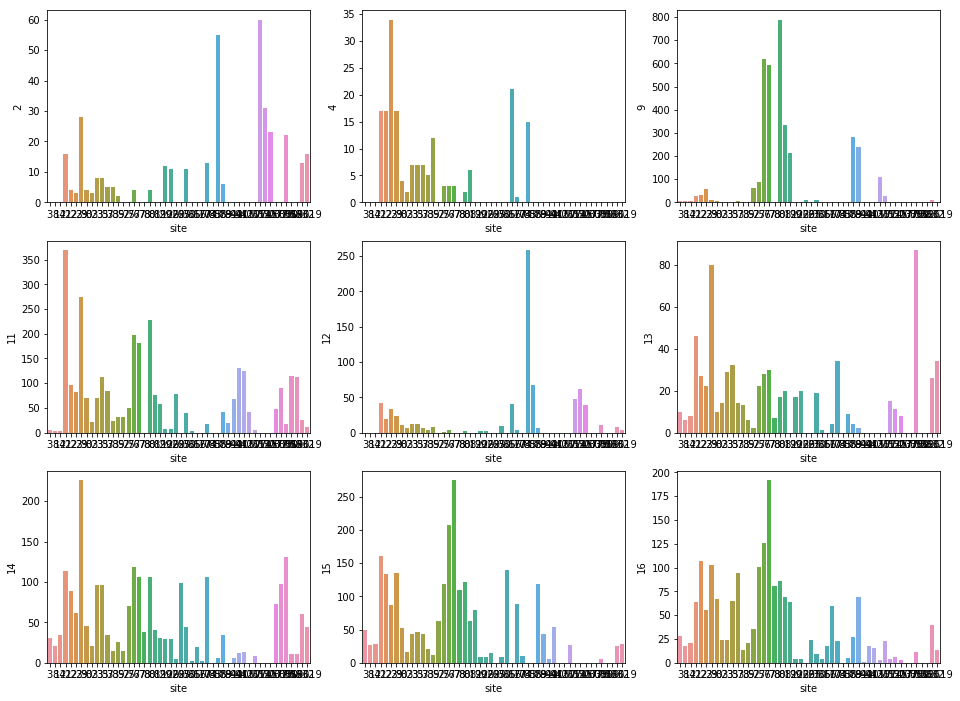

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for i in range(len(df_plot.columns)):
    sns.barplot(x=df_plot.index, y=df_plot.columns[i], data=df_plot, ax=axes[i//3, i%3]);

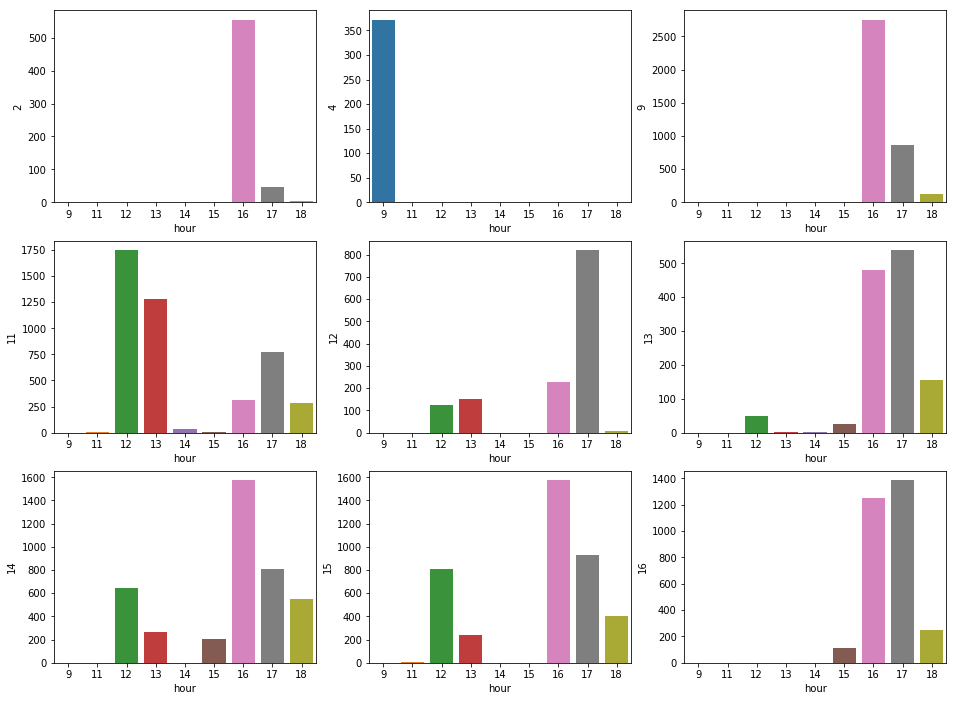

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for i in range(len(df_plot_h.columns)):
    sns.barplot(x=df_plot_h.index, y=df_plot_h.columns[i], data=df_plot_h, ax=axes[i//3, i%3]);

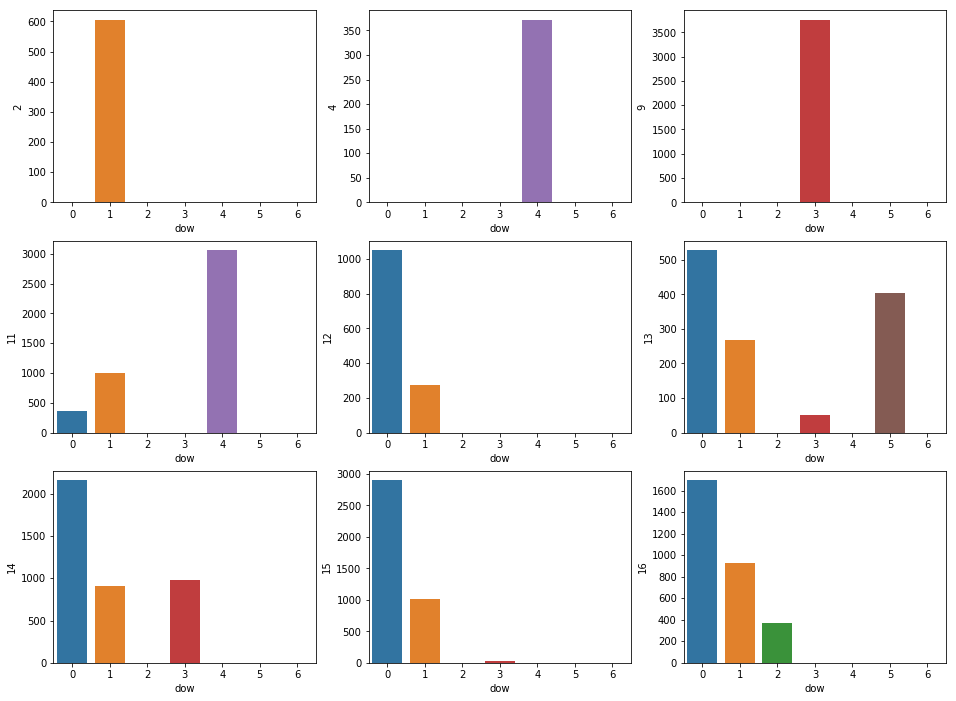

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for i in range(len(df_plot_dow.columns)):
    sns.barplot(x=df_plot_dow.index, y=df_plot_dow.columns[i], data=df_plot_dow, ax=axes[i//3, i%3]);